In [1]:
# this clones the PGM repository in the ./PGM folder if it does not exists
# please modify this line as needed if you want to have the PMG repository elsewhere
import os, sys
pgm_path = './PGM/'
if not os.path.isdir(pgm_path): # check if folder exists
    from git import Repo
    Repo.clone_from("https://github.com/jertubiana/PGM.git", pgm_path)
sys.path.append('./PGM/source/')
sys.path.append('./PGM/utilities/')
sys.path.append('./DNA_utils/')

In [2]:
# imports
from common_imports import set_num_threads
set_num_threads(2) # Set the number of cores. Must be executed before importing numpy&numba.
import rbm, RBM_utils, utilities
import DNA_utils, DNA_sequence_logo, DNA_plots_utils

import pandas as pd
import numpy as np
import string

from matplotlib import pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as patches
import matplotlib.lines as lines
from matplotlib.lines import Line2D

%matplotlib inline

./PGM/source\numba_utilities.py:1124: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(float32, 2d, F), array(float32, 2d, A))
  dmean_v_dw = np.dot(s1.T, V)
./PGM/source\numba_utilities.py:961: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(float32, 1d, A), array(float32, 2d, A))
  mean_V = np.dot(weights, V) / sum_weights


In [5]:
# load round 8 data
path = './data/'
filename = 's100_8th.fasta'
all_data_8, counts_8 = DNA_utils.load_DNA_MSA(path + filename, drop_duplicates=True, with_counts = True)
full_data_8 = np.repeat(all_data_8, counts_8, axis=0)

# split left and right data
seqs_8_l_2num, counts_8_l = np.unique(full_data_8[:, :20], return_counts=True, axis=0)
all_data_8_l = pd.DataFrame({'sequence' : DNA_utils.num2seq(seqs_8_l_2num),
                             'counts' : counts_8_l})

seqs_8_r_2num, counts_8_r = np.unique(full_data_8[:, 20:], return_counts=True, axis=0)
all_data_8_r = pd.DataFrame({'sequence' : DNA_utils.num2seq(seqs_8_r_2num),
                             'counts' : counts_8_r})

# put both rounds together
all_data_8_lr = pd.concat([all_data_8_l, all_data_8_r])
all_data_8_lr = all_data_8_lr.reset_index(drop=True)
all_data_8_lr = all_data_8_lr.groupby(by=["sequence"], as_index=False).sum()
all_data_8_lr = all_data_8_lr.sort_values(by='counts', ascending=False).reset_index(drop=True)
all_seq_8_lr = DNA_utils.seq2num(all_data_8_lr["sequence"].to_list())
counts_8_lr = all_data_8_lr['counts'].to_numpy()

In [6]:
# load pre-trained RBMs
path = './trained_RBMs/'
file_name = 'RBM_DC8.data'
RBM_DC8 = RBM_utils.loadRBM(path+file_name)

file_name = 'RBM_SC8.data'
RBM_SC8 = RBM_utils.loadRBM(path + file_name)

In [7]:
# prepare data for RBM_D8
#select the top-norm weights on left and right
order = np.argsort(-RBM_utils.get_norm(RBM_DC8.weights))
sorted_weights_D8 = RBM_DC8.weights[order]
# compute inputs
I_D8_c  = RBM_DC8.input_hiddens(all_data_8)

In [8]:
# prepare data for RBM_SC8
beta = RBM_utils.get_norm(RBM_SC8.weights)
order_S = np.argsort(beta)[::-1]
# compute inputs to HUs
I_S_c  = RBM_SC8.input_hiddens(all_seq_8_lr)
# prepare aptamers from families in the Zhou et al.'s (10.1002/cbic.201900265) work, and sort weights by norm
fam_models = {
    'A':['AGGGATGATGTGTGGTAGGC', 'AGGGTTGATGTGTGGTAGGC', 'AGGGATGATGCGTGGTAGGC'],
    'B':['AGGGTAGGTGTGGATGATGC', 'AGGGTAGGCGTGGATGATGC', 'AGGGTAGGAGTGGATGATGC', 'AGGGTAGGGGTGGATGATGC'],
    'C':['TAGGTTTTGGGTAGGGTGGT', 'TAGGTTATGGGTAGGGTGGT', 'TAGGTCTTGGGTAGGGTGGT', 'TAGGTGTTGGGTAGGGTGGT',
             'TAGGTTGTGGGTAGGGTGGT'],
    'D':['CTAGGTTGGGTAGGGTGGTG', 'CTAGGATGGGTAGGGTGGTG', 'GTAGGGTGGGTAGGGTGGTC', 'GTAGGTTGGGTAGGGTGGTC',
             'GTAGGATGGGTAGGGTGGTC', 'ATAGGATGGGTAGGGTGGTT', 'CTAGGGTGGGTAGGATGGTG', 'ATAGGTTGGGTAGGGTGGTT']
}

./PGM/source\layer.py:1188: RuntimeWarning: overflow encountered in true_divide
  p_plus = 1 / (1 + (etg_minus / np.sqrt(self._gamma_minus)
./PGM/source\layer.py:1188: RuntimeWarning: overflow encountered in true_divide
  p_plus = 1 / (1 + (etg_minus / np.sqrt(self._gamma_minus)
./PGM/source\layer.py:1188: RuntimeWarning: overflow encountered in true_divide
  p_plus = 1 / (1 + (etg_minus / np.sqrt(self._gamma_minus)


Text(0.5, 0, 'Input')

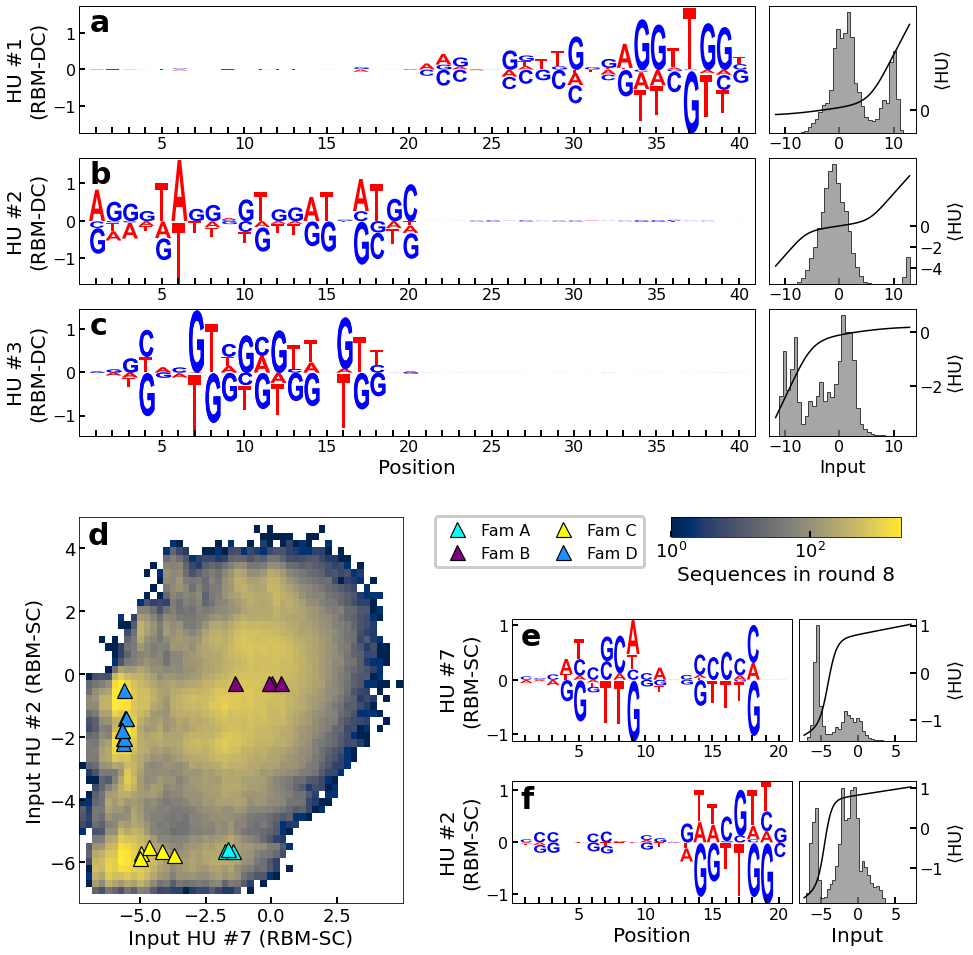

In [9]:
# make figure
add_input_means = True
add_cgfs = False
n_weights = 3
#wdict = [3,11,8]
wdict = [0,1,2]
lims = [(-4,1), (-2, 2), (-6, 3), (-5,1), (-5,2)]

if add_cgfs:
    lims = [(np.sum(np.min(w,axis=1)),np.sum(np.max(w,axis=1)))  for w in RBM_DC8.weights]
    npoints = 1000
    fullranges = np.array([np.arange(x[0], x[1], (x[1]-x[0]+1/npoints)/npoints) for x in lims], dtype=np.float32)
    pre_cgfs = RBM_DC8.hlayer.cgf_from_inputs(fullranges.transpose())
    
fig = plt.figure(figsize=(15, n_weights * 5.5), constrained_layout=False)
wr = [0.2, 0.7, 0.2]
hr = [1, 0.9]
gs = fig.add_gridspec(ncols=3, nrows=2, wspace=0.1, hspace=0.2, width_ratios=wr, height_ratios=hr)
##########################################################################################################################
##########################################################################################################################
##########################################################################################################################
t_gs = gs[0, :].subgridspec(ncols=3, nrows=n_weights, wspace=0.05, hspace=0.2, width_ratios=wr)
for i in range(n_weights):
    t_ax = fig.add_subplot(t_gs[i,0:2])
    DNA_sequence_logo.Sequence_logo(sorted_weights_D8[wdict[i]], ticks_every=5, ylabel="HU #"+str(wdict[i]+1)+"\n(RBM-DC)", #RBM-D8
                                    ticks_labels_size=16, title_size=20, ax=t_ax);
    if i == n_weights-1:
        DNA_sequence_logo.Sequence_logo(sorted_weights_D8[wdict[i]], ticks_every=5, ylabel="HU #"+str(wdict[i]+1)+"\n(RBM-DC)", #RBM-D8
                                    ticks_labels_size=16, title_size=20, ax=t_ax);
        t_ax.set_xlabel("Position", fontsize=20)
    t_rect = patches.Rectangle((0.0, 0.0), 1, 1, linewidth=1, edgecolor='black',
                               facecolor='none', transform=t_ax.transAxes, clip_on=False)    
    t_ax.add_patch(t_rect)
    t_ax.tick_params(axis='both', direction='in', length=6, width=2, colors='k')
    t_ax.tick_params(which='minor', direction='in', length=0, width=2, colors='k')
    t_ax.text(0.015, 0.8, string.ascii_lowercase[i], fontsize=30, color='k', 
              weight='bold', transform=t_ax.transAxes)
##########################################################################################################################
    t_ax2 = fig.add_subplot(t_gs[i,2])
    ix = order[wdict[i]]
    if not add_cgfs and not add_input_means:
        t_ax2.hist(I_lr_c[:, ix], bins=30, color='grey', label='All sequences', weights=counts_8, density=True,
               histtype='step', lw=3, fill=True, alpha=0.7, edgecolor='black', linewidth=1)
    if add_input_means:
        t_ax22 = t_ax2.twinx()
        I_min = I_D8_c.min()
        I_max = I_D8_c.max()
        I_range = np.asarray((I_max-I_min) * np.arange(0,1+0.01,0.01) + I_min, dtype=np.float32)
        mean = RBM_DC8.hlayer.mean_from_inputs(np.repeat(I_range[:,np.newaxis], RBM_DC8.n_h, axis=1))
        t_x = I_range
        t_y = mean[:, ix]
        t_ax22.plot(t_x, t_y, color='k')
        counts, bins = np.histogram(I_D8_c[:, ix], bins=30, weights=counts_8)
        factor = np.max(t_y) / np.max(counts)
        n,b,p = t_ax2.hist(bins[:-1], bins, color='grey', label='All sequences', weights=counts*factor,
                   histtype='step', lw=3, fill=True, alpha=0.7, edgecolor='black', linewidth=1)
        t_ax2.set_yticks([])
        t_ax22.set_yticks([0, -2, -4])
        t_ax22.set_ylim((min(t_y) - (max(t_y) - min(t_y))/5, max(t_y) + (max(t_y) - min(t_y))/5))
        t_ax22.set_ylabel(r'$\langle$HU$\rangle$', fontsize=18)
        t_ax22.tick_params(axis='both', direction='in', length=6, width=2, colors='k')
        t_ax22.tick_params(axis='both', labelsize=16) 
    if add_cgfs:
        t_x = fullranges[ix]
        t_y = pre_cgfs[:, ix]
        counts, bins = np.histogram(I_D8_c[:, ix], bins=30, weights=counts_8)
        factor = np.max(t_y) / np.max(counts)
        n,b,p = t_ax2.hist(bins[:-1], bins, color='grey', label='All sequences', weights=counts*factor,
                   histtype='step', lw=3, fill=True, alpha=0.7, edgecolor='black', linewidth=1)
        deltay = np.min(t_y)
        t_ax2.plot(t_x, t_y - deltay, lw=3, color='C1')
        t_ax2.set_ylabel('CGF', fontsize=18)
    if i == n_weights-1:
        t_ax2.set_xlabel('Input', fontsize=18)
    t_ax2.tick_params(axis='both', direction='in', length=6, width=2, colors='k')
    t_ax2.tick_params(axis='both', labelsize=16)
    t_ax2.yaxis.tick_right()
    t_ax2.yaxis.set_label_position("right")
##########################################################################################################################
##########################################################################################################################
##########################################################################################################################
# setting for second part of the plot
px = 6
py = 1
wx = order_S[px]
wy = order_S[py]

wr2 = [0.8, 1]
t_gs = gs[1, :].subgridspec(ncols=2, nrows=1, wspace=0.3, width_ratios=wr2)

##########################################################################################################################
##########################################################################################################################

fam_colors = {'A':'cyan', 'B':'purple', 'C': 'yellow', 'D':'dodgerblue', 'TBA_opt':'red', 'HD22_opt':'blue'}
fam_legends = {'A':'A', 'B':'B', 'C': 'C', 'D':'D'}

ax = fig.add_subplot(t_gs[0,0])
# plot 2d hist for all 8th round dataset
t_x = I_S_c[:, wx]
t_y = I_S_c[:, wy]
h2d = ax.hist2d(t_x, t_y, bins=50, cmap='cividis', norm=mcolors.LogNorm(vmin=1, vmax=2000))#min=1, vmax=20000))
# plot points for family members
for key in fam_models:
    I_fam_seq = RBM_SC8.input_hiddens(DNA_utils.seq2num(fam_models[key]))
    t_x = I_fam_seq[:, wx]
    t_y = I_fam_seq[:, wy]
    ax.plot(t_x, t_y,'^', alpha=1, color=fam_colors[key], markeredgewidth=1.2,
                markeredgecolor="black", markersize=15, label='Fam '+fam_legends[key], zorder=2)
        
ax.set_ylabel('Input HU #' + str(py+1) + " (RBM-SC)", fontsize=20) #RBM-S8
#ax.yaxis.set_label_coords(-0.08, 0.5)
ax.set_xlabel('Input HU #' + str(px+1) + " (RBM-SC)", fontsize=20) #RBM-S8
ax.tick_params(axis='both', direction='in', length=6, width=2, colors='k')
ax.tick_params(which='minor', direction='out', length=0, width=2, colors='k')
ax.tick_params(axis='both', labelsize=18)
#ax.set_ylim((-4.1, 7))
ax.text(0.025, 0.93, 'd', fontsize=30, 
         color='k', weight='bold', transform=ax.transAxes)

l = ax.legend(framealpha=1, fontsize=16, ncol=2, loc=(1.1, 0.87),
              columnspacing=1, handletextpad=0.5)
l.get_frame().set_linewidth(3)
ax.set_ylim((-7.3, 5))

##########################################################################################################################
##########################################################################################################################
wr3 = [0.35, 0.35, 0.3]
hr3 = [0.2, 0.4, 0.4]
t2_gs = t_gs[0, 1].subgridspec(ncols=3, nrows=3, hspace=0.4, wspace=0.05, width_ratios=wr3, height_ratios=hr3)

###########################################################################################################################
## colorbar
#fax = fig.add_subplot(gs[1,:])
tt_gs = t2_gs[0, 1:].subgridspec(ncols=3, nrows=3, wspace=0.2, hspace=0., width_ratios=[0.0, 1, 0.0])
ax_cb = fig.add_subplot(tt_gs[0, 1])
fig.colorbar(h2d[3], cax=ax_cb, orientation='horizontal') 
ax_cb.tick_params(axis='both', direction='in', length=6, width=2, colors='k')
ax_cb.tick_params(which='minor', direction='in', length=0, width=2, colors='k')
ax_cb.tick_params(axis='both', labelsize=18)
ax_cb.set_xlabel('Sequences in round 8', fontsize=20)
###########################################################################################################################

ps = [px, py]
panel_labels = ['e', 'f']
for i,p in enumerate(ps):    
    w = order_S[p]
    t_ax = fig.add_subplot(t2_gs[i+1,0:2])
    DNA_sequence_logo.Sequence_logo(RBM_SC8.weights[w], ticks_every=5, ylabel="HU #"+str(p+1)+"\n(RBM-SC)", 
                                    ticks_labels_size=16, title_size=20, ax=t_ax);
    if i == n_weights-1:
        DNA_sequence_logo.Sequence_logo(RBM_SC8.weights[w], ticks_every=5, ylabel="HU #"+str(p+1)+"\n(RBM-SC)", 
                                    ticks_labels_size=16, title_size=20, ax=t_ax);
        t_ax.set_xlabel("Position", fontsize=20)
    t_rect = patches.Rectangle((0.0, 0.0), 1, 1, linewidth=1, edgecolor='black',
                               facecolor='none', transform=t_ax.transAxes, clip_on=False)    
    t_ax.add_patch(t_rect)
    t_ax.tick_params(axis='both', direction='in', length=6, width=2, colors='k')
    t_ax.tick_params(which='minor', direction='in', length=0, width=2, colors='k')
    t_ax.text(0.03, 0.78, panel_labels[i], fontsize=30, color='k', 
              weight='bold', transform=t_ax.transAxes)
    
##########################################################################################################################
    t_ax2 = fig.add_subplot(t2_gs[i+1,2])
    ix = order_S[p]
    if not add_cgfs and not add_input_means:
        t_ax2.hist(I_S_c[:, ix], bins=30, color='grey', label='All sequences', weights=counts_8_lr, density=True,
               histtype='step', lw=3, fill=True, alpha=0.7, edgecolor='black', linewidth=1)
    if add_input_means:
        t_ax22 = t_ax2.twinx()
        I_min = I_S_c.min()
        I_max = I_S_c.max()
        I_range = np.asarray((I_max-I_min) * np.arange(0,1+0.01,0.01) + I_min, dtype=np.float32)
        mean = RBM_SC8.hlayer.mean_from_inputs(np.repeat(I_range[:,np.newaxis], RBM_SC8.n_h, axis=1))
        t_x = I_range
        t_y = mean[:, ix]
        t_ax22.plot(t_x, t_y, color='k')
        counts, bins = np.histogram(I_S_c[:, ix], bins=30, weights=counts_8_lr)
        factor = np.max(t_y) / np.max(counts)
        n,b,p = t_ax2.hist(bins[:-1], bins, color='grey', label='All sequences', weights=counts*factor,
                   histtype='step', lw=3, fill=True, alpha=0.7, edgecolor='black', linewidth=1)
        t_ax2.set_yticks([])
        t_ax22.set_ylabel(r'$\langle$HU$\rangle$', fontsize=18)
        t_ax22.tick_params(axis='both', direction='in', length=6, width=2, colors='k')
        t_ax22.tick_params(axis='both', labelsize=16) 
    if add_cgfs:
        t_x = fullranges[ix]
        t_y = pre_cgfs[:, ix]
        counts, bins = np.histogram(I_S_c[:, ix], bins=30, weights=counts_8_lr)
        factor = np.max(t_y) / np.max(counts)
        n,b,p = t_ax2.hist(bins[:-1], bins, color='grey', label='All sequences', weights=counts*factor,
                   histtype='step', lw=3, fill=True, alpha=0.7, edgecolor='black', linewidth=1)
        deltay = np.min(t_y)
        t_ax2.plot(t_x, t_y - deltay, lw=3, color='C1')
        t_ax2.set_ylabel('CGF', fontsize=18)
    if i == n_weights-1:
        t_ax2.set_xlabel('Input', fontsize=18)
    t_ax2.tick_params(axis='both', direction='in', length=6, width=2, colors='k')
    t_ax2.tick_params(axis='both', labelsize=16)
    t_ax2.yaxis.tick_right()
    t_ax2.yaxis.set_label_position("right")
t_ax.set_xlabel("Position", fontsize=20)
t_ax2.set_xlabel("Input", fontsize=20)
###########################################################################################################################